In [22]:
import json
import time
import random
import pymongo
import copy
import MyCommon
from pymongo import MongoClient
from collections import deque
import cassiopeia
from cassiopeia import riotapi
import numpy as np
from sklearn import preprocessing, cluster, decomposition
from scipy.cluster.vq import kmeans,vq
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.decomposition import FastICA, PCA
from sklearn import metrics

riotapi.set_region("KR")
riotapi.set_api_key("79428a9e-5d98-469b-9b9b-429c1a750d24")
riotapi.set_rate_limits((10, 10), (500, 600))
riotapi.print_calls(True)

In [3]:
client = MongoClient()
loladb = client.loladb
summoners_collection = loladb.summoners
matches_collection = loladb.matches
print summoners_collection.count()
print matches_collection.count()

839
3600


In [4]:
def CountFullGrabbedSummoners():
    counter = 0
    for a_summoner in summoners_collection.find():
        if 'fullGrabbed' in a_summoner.keys():
            counter += 1
    return counter
    
first_summoner = summoners_collection.find_one()
print first_summoner
print CountFullGrabbedSummoners()

{u'isFreshBlood': False, u'division': u'I', u'miniSeries': None, u'wins': 373, u'losses': 229, u'playerOrTeamId': u'2924890', u'latestGrabbedMatchId': 2646759227L, u'playerOrTeamName': u'\uc21c\ubc94\uc784', u'fullGrabbed': True, u'isHotStreak': False, u'isInactive': False, u'_id': ObjectId('583e9beb4b836b107c6677fc'), u'isVeteran': True, u'leaguePoints': 10}
839


In [77]:
#create a champ convert dictionary to get champ idx from id, idx range from [0, 133)
#also provide functions to get champ names from id
champions = riotapi.get_champions()
dict_id2idx = dict()
dict_idx2id = dict()
dict_id2key = dict()
for a_idx, a_champion in enumerate(champions):
    champ_id = a_champion.id
    champ_key = a_champion.key
    dict_id2idx[champ_id] = a_idx
    dict_idx2id[a_idx] = champ_id
    dict_id2key[champ_id] = champ_key
    
#print dict_id2key[dict_idx2id[132]]
#print dict_id2key

def GetIdxFromId(a_id):
    return dict_id2idx[a_id]

def GetIdFromIdx(a_idx):
    return dict_idx2id[a_idx]

def GetNameFromId(a_id):
    return dict_id2key[a_id]

In [6]:
CHAMP_NUM = 133
FEATURE_NUM = 33
KILL_START = FEATURE_NUM
ASSIST_START = FEATURE_NUM + CHAMP_NUM
champ_features_sum = np.zeros((CHAMP_NUM, FEATURE_NUM + CHAMP_NUM * 2))
champ_features_time = np.zeros((CHAMP_NUM, FEATURE_NUM + CHAMP_NUM * 2))

def FillStaticFeatureForParticipant(a_participant):
    champ_id = a_participant['championId']
    champ_idx = GetIdxFromId(champ_id)
    champ_name = GetNameFromId(champ_id)
    static_features = np.zeros((1, FEATURE_NUM))
    static_features[0, 0] = a_participant['stats']['assists']
    static_features[0, 1] = a_participant['stats']['deaths']
    static_features[0, 2] = a_participant['stats']['doubleKills']
    static_features[0, 3] = int(a_participant['stats']['firstBloodAssist'])
    static_features[0, 4] = int(a_participant['stats']['firstBloodKill'])
    static_features[0, 5] = int(a_participant['stats']['firstTowerAssist'])
    static_features[0, 6] = int(a_participant['stats']['firstTowerKill'])
    static_features[0, 7] = a_participant['stats']['goldEarned']
    static_features[0, 8] = a_participant['stats']['inhibitorKills']
    static_features[0, 9] = a_participant['stats']['killingSprees']
    static_features[0, 10] = a_participant['stats']['kills']
    static_features[0, 11] = a_participant['stats']['largestKillingSpree']
    static_features[0, 12] = a_participant['stats']['magicDamageDealt']
    static_features[0, 13] = a_participant['stats']['magicDamageDealtToChampions']
    static_features[0, 14] = a_participant['stats']['minionsKilled']
    static_features[0, 15] = a_participant['stats']['neutralMinionsKilledEnemyJungle']
    static_features[0, 16] = a_participant['stats']['neutralMinionsKilledTeamJungle']
    static_features[0, 17] = a_participant['stats']['pentaKills']
    static_features[0, 18] = a_participant['stats']['physicalDamageDealt']
    static_features[0, 19] = a_participant['stats']['physicalDamageDealtToChampions']
    static_features[0, 20] = a_participant['stats']['quadraKills']
    static_features[0, 21] = a_participant['stats']['sightWardsBoughtInGame']
    static_features[0, 22] = a_participant['stats']['totalHeal']
    static_features[0, 23] = a_participant['stats']['totalTimeCrowdControlDealt']
    static_features[0, 24] = a_participant['stats']['totalUnitsHealed']
    static_features[0, 25] = a_participant['stats']['towerKills']
    static_features[0, 26] = a_participant['stats']['tripleKills']
    static_features[0, 27] = a_participant['stats']['trueDamageDealt']
    static_features[0, 28] = a_participant['stats']['trueDamageDealtToChampions']
    static_features[0, 29] = a_participant['stats']['visionWardsBoughtInGame']
    static_features[0, 30] = a_participant['stats']['wardsKilled']
    static_features[0, 31] = a_participant['stats']['wardsPlaced']
    static_features[0, 32] = int(a_participant['stats']['winner'])
    
    champ_features_sum[champ_idx, 0:FEATURE_NUM] += static_features[0, :]
    champ_features_time[champ_idx, 0:FEATURE_NUM] += 1
    
def ProcessKillEvent(a_event, participants):
    if a_event['eventType'] == 'CHAMPION_KILL':
        kill_participant_id = a_event['killerId']
        victim_participant_id = a_event['victimId']
        assist_participant_ids = a_event['assistingParticipantIds']
        
        kill_champ_id = participants[kill_participant_id - 1]['championId']
        victim_champ_id = participants[victim_participant_id - 1]['championId']
        assist_champ_ids = []
        for participant_id in assist_participant_ids:
            assist_champ_ids.append(participants[participant_id - 1]['championId'])
            
        victim_champ_idx = GetIdxFromId(victim_champ_id)
        kill_champ_idx = GetIdxFromId(kill_champ_id)
        
        champ_features_sum[kill_champ_idx, KILL_START + victim_champ_idx] += 1
        for assist_id in assist_champ_ids:
            assist_idx = GetIdxFromId(assist_id)
            champ_features_sum[assist_idx, ASSIST_START + victim_champ_idx] += 1

def FillFeaturesFromMatch(a_match):
    participants = a_match['participants']
    #parse feature for each partifipants
    for a_idx,a_participant in enumerate(participants):
        FillStaticFeatureForParticipant(a_participant)
    
    #parse feature from events: kill and assist
    kill_count = 0
    timeline_frames = a_match['timeline']['frames']
    for frame_idx, each_frame in enumerate(timeline_frames):
        events = each_frame['events']
        for event_idx, each_event in enumerate(events):
            if each_event['eventType'] == 'CHAMPION_KILL':
                #print each_event
                ProcessKillEvent(each_event, participants)
                
    for participant_idx in range(5):
        source_id = participants[participant_idx]['championId']
        source_idx = GetIdxFromId(source_id)
        for another_idx in range(5, 10):
            target_id = participants[another_idx]['championId']
            target_idx = GetIdxFromId(target_id)
            champ_features_time[source_idx][KILL_START + target_idx] += 1
            champ_features_time[source_idx][ASSIST_START + target_idx] += 1
            
    for participant_idx in range(5, 10):
        source_id = participants[participant_idx]['championId']
        source_idx = GetIdxFromId(source_id)
        for another_idx in range(5):
            target_id = participants[another_idx]['championId']
            target_idx = GetIdxFromId(target_id)
            champ_features_time[source_idx][KILL_START + target_idx] += 1
            champ_features_time[source_idx][ASSIST_START + target_idx] += 1

    
for a_idx, a_match in enumerate(matches_collection.find()):
    if a_idx % 100 == 0:
        print a_idx
    FillFeaturesFromMatch(a_match)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500


In [7]:
champ_nozero_time = champ_features_time[:, :]
champ_nozero_time[champ_nozero_time == 0] = 1
champ_features = champ_features_sum / champ_nozero_time
#print champ_features[6, :]


champ_features_scaled = preprocessing.scale(champ_features)
print champ_features_scaled[:, 0].mean()
print champ_features_scaled[:, 0].std()
#print champ_features_sum[6, :]/champ_time

-3.60613794465e-16
1.0


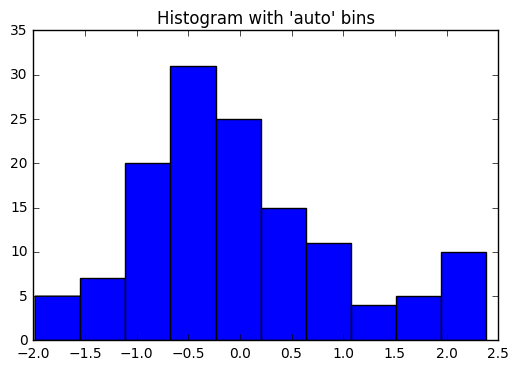

In [9]:
import matplotlib.pyplot as plt

plt.hist(champ_features_scaled[:, 0], bins='auto')
plt.title("Histogram with 'auto' bins")
plt.show()

In [10]:
# computing K-Means with K = 2 (2 clusters)
centroids,_ = kmeans(champ_features_scaled,10)
# assign each sample to a cluster
idx,_ = vq(champ_features_scaled,centroids)

In [75]:
for cluster_idx in range(15):
    print cluster_idx
    for champ_idx,a_idx in enumerate(idx):
        if a_idx == cluster_idx:
            champ_id = GetIdFromIdx(champ_idx)
            champ_name = GetNameFromId(champ_id)
            print champ_name

0
Shaco
Nidalee
Karthus
Shyvana
Kindred
Nocturne
Vi
1
Zyra
Braum
MissFortune
Blitzcrank
Maokai
Thresh
Karma
Bard
Morgana
Ivern
Leona
Alistar
TahmKench
Nami
Soraka
Janna
Nautilus
2
Corki
Xerath
Orianna
Fizz
Kassadin
Viktor
Cassiopeia
Syndra
Ryze
TwistedFate
Taliyah
Velkoz
Varus
Katarina
Ekko
AurelionSol
Ahri
Malzahar
Lissandra
Zed
3
Brand
Trundle
Sona
Annie
Shen
Zac
Sion
Zilean
Nunu
Gragas
Lulu
Taric
4
Sivir
Lucian
Jinx
Kalista
Talon
Vayne
Caitlyn
Ashe
Twitch
Draven
Jhin
Ezreal
5
MonkeyKing
Warwick
Illaoi
Tryndamere
Yorick
DrMundo
Volibear
Sejuani
Teemo
Urgot
Galio
Heimerdinger
Skarner
Garen
MasterYi
Aatrox
FiddleSticks
XinZhao
Tristana
Veigar
Quinn
6
Rammus
Malphite
Lux
Vladimir
Kayle
Ziggs
Swain
Nasus
Chogath
Udyr
Azir
Amumu
Anivia
Singed
Mordekaiser
KogMaw
Diana
JarvanIV
7
Jayce
Graves
Hecarim
Khazix
Rengar
Rumble
Elise
LeeSin
RekSai
Evelynn
Leblanc
8
Jax
Kled
Darius
Riven
Gangplank
Poppy
Gnar
Renekton
Fiora
Olaf
Akali
Yasuo
Kennen
Pantheon
Irelia
9
10
11
12
13
14


In [81]:
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
from itertools import cycle

def ShowAffinityPropagationDemo():
    centers = [[1, 1], [-1, -1], [1, -1]]
    X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5, random_state=0)
    print X.shape
    #plt.plot(X[:, 0], X[:, 1], 'ro')
    #plt.show()
    af = AffinityPropagation(preference=-50).fit(X)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_

    n_clusters_ = len(cluster_centers_indices)

    print('Estimated number of clusters: %d' % n_clusters_)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
    print("Adjusted Rand Index: %0.3f"
          % metrics.adjusted_rand_score(labels_true, labels))
    print("Adjusted Mutual Information: %0.3f"
          % metrics.adjusted_mutual_info_score(labels_true, labels))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

    plt.close('all')
    plt.figure(1)
    plt.clf()

    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(n_clusters_), colors):
        class_members = labels == k
        cluster_center = X[cluster_centers_indices[k]]
        plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)
        for x in X[class_members]:
            plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
af = AffinityPropagation(preference=-300).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)
idx = labels
print('Estimated number of clusters: %d' % n_clusters_)

for i in range(15):
    print sum(idx == i)

labels.tofile("cluster_labels.txt",sep=" ",format="%s")

Estimated number of clusters: 9
7
17
20
12
12
21
18
11
15
0
0
0
0
0
0


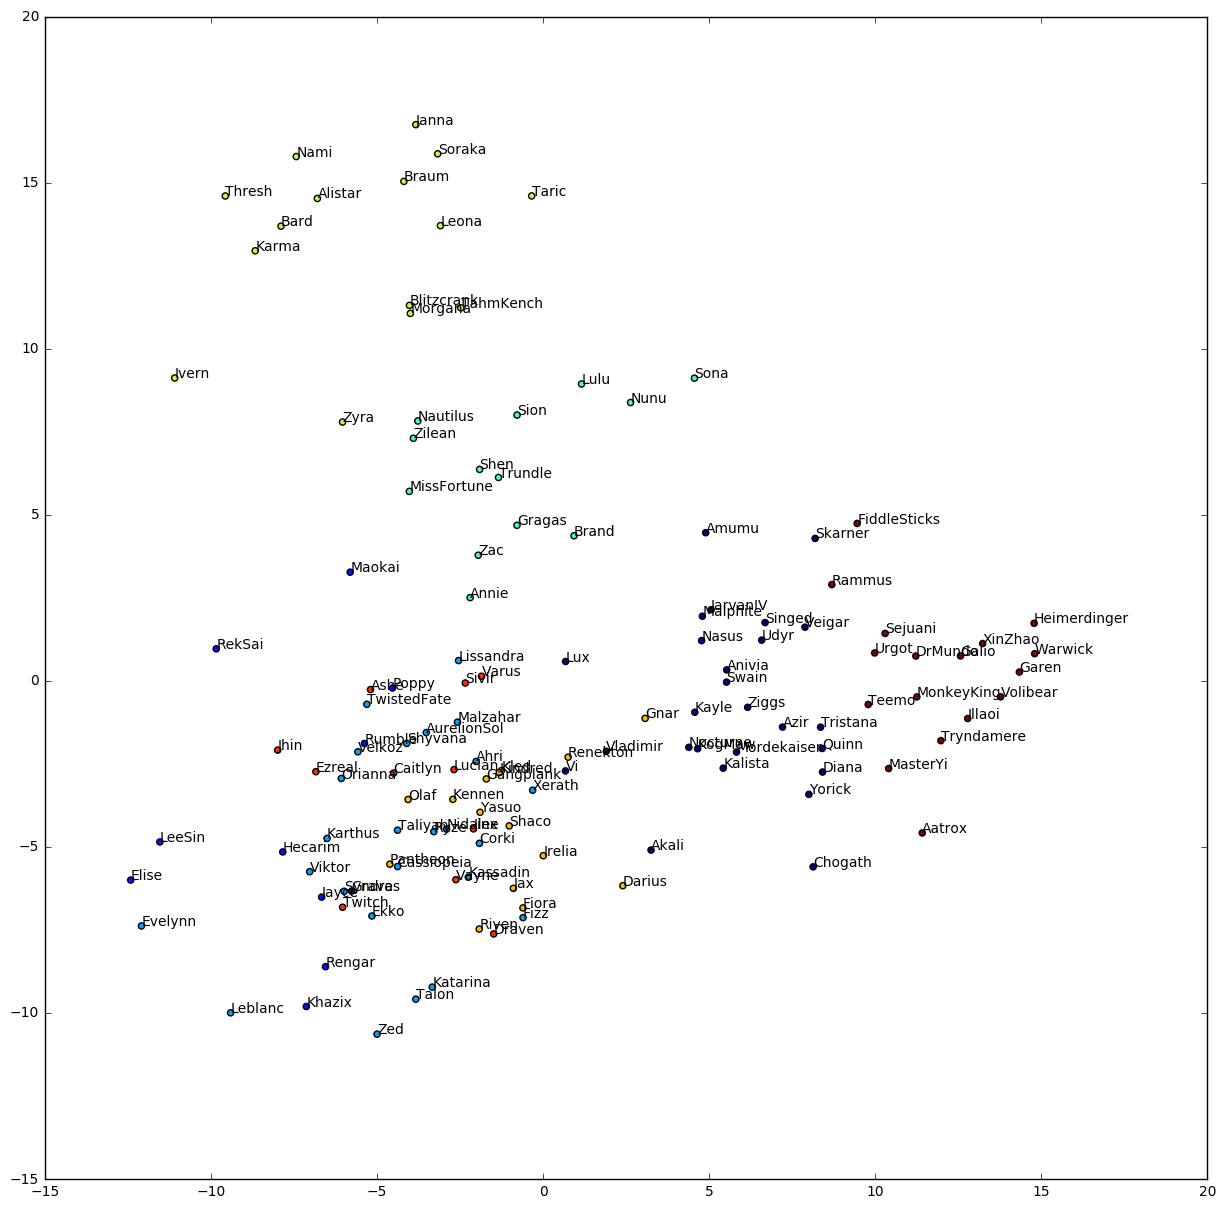

In [65]:
pca = decomposition.PCA(n_components=10)
pca.fit(champ_features_scaled)
#pca(copy=True, n_components=2, whiten=False)
X = pca.transform(champ_features_scaled)

reduced_data = X
kmeans = KMeans(init='k-means++', n_clusters=8, n_init=10)
kmeans.fit(reduced_data)
idx = kmeans.predict(reduced_data)

import pylab as pl
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.scatter(X[:, 0], X[:, 1], c=idx) 
for i in range(CHAMP_NUM):
    champ_id = GetIdFromIdx(i)
    champ_name = GetNameFromId(champ_id)
    ax.annotate(champ_name, (X[i, 0], X[i, 1]))
pl.show()

In [13]:
#draw the curve of error vs k number
static_features_scaled = champ_features_scaled[:, 0:33]
#print static_features_scaled.shape
#centroids,_ = kmeans(static_features_scaled,10)
# assign each sample to a cluster
#idx,_ = vq(static_features_scaled,centroids)
sk_kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10, max_iter=30000)
sk_kmeans.fit(static_features_scaled)
idx = sk_kmeans.predict(static_features_scaled)

In [14]:
static_with_kill_scaled = champ_features_scaled[:, 0:CHAMP_NUM+FEATURE_NUM]
sk_kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10, max_iter=3000)
sk_kmeans.fit(static_with_kill_scaled)
idx = sk_kmeans.predict(static_with_kill_scaled)

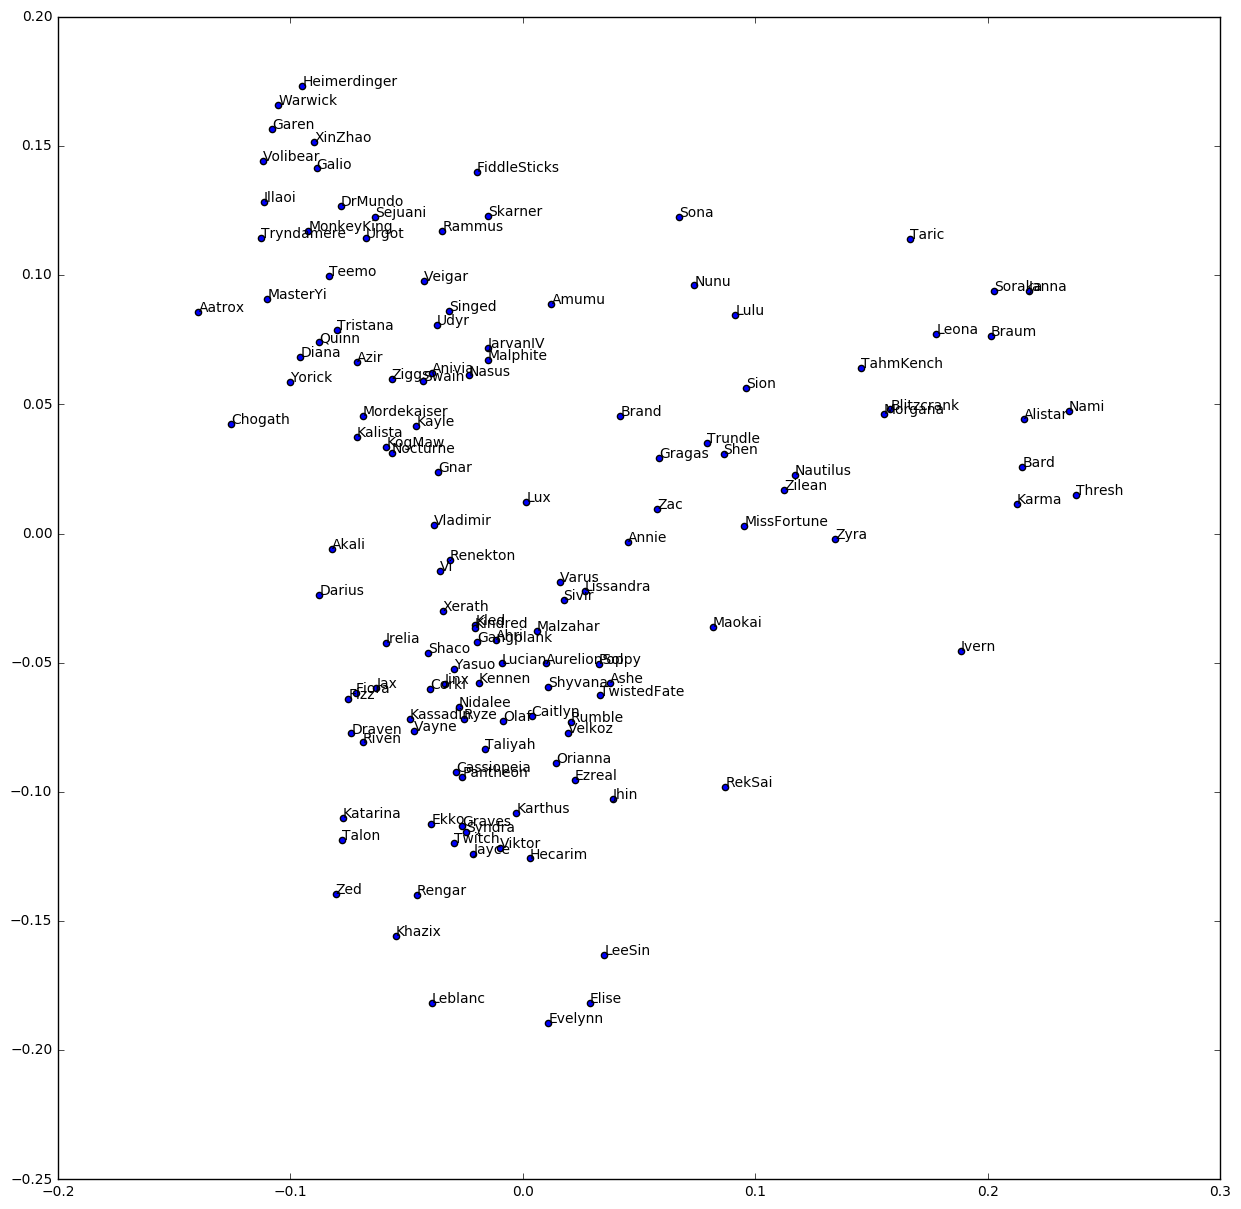

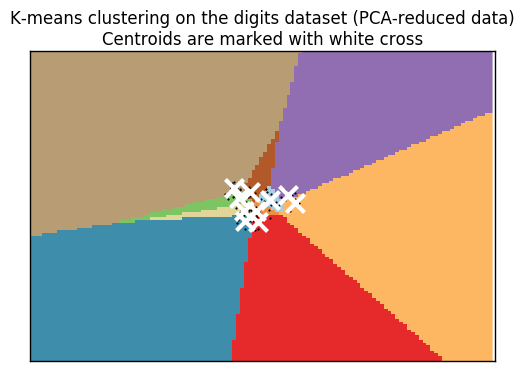

In [15]:
ica = FastICA(n_components=2)
X = ica.fit_transform(champ_features_scaled)
fig, ax = plt.subplots(1, 1, figsize=(15,15))
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1]) 
for i in range(CHAMP_NUM):
    champ_id = GetIdFromIdx(i)
    champ_name = GetNameFromId(champ_id)
    ax.annotate(champ_name, (X[i, 0], X[i, 1]))
pl.show()

reduced_data = X
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

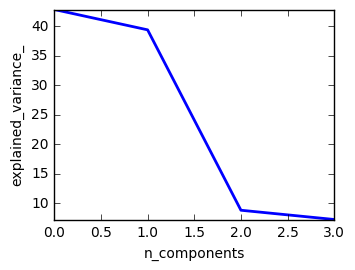

In [16]:
pca.fit(champ_features_scaled)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

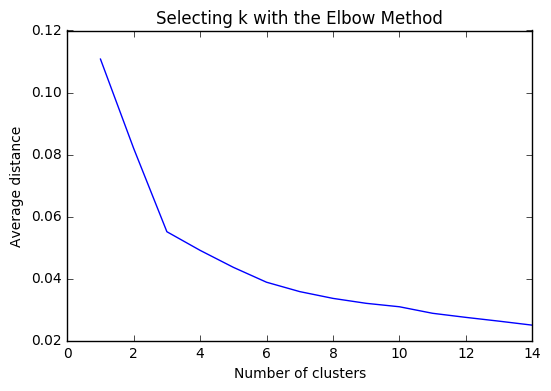

In [17]:
from scipy.spatial.distance import cdist
clusters = range(1, 15)
meandist = []

for k in clusters:
    model = KMeans(n_clusters = k)
    model.fit(X)
    clusassign = model.predict(X)
    meandist.append(sum(np.min(cdist(X, model.cluster_centers_, 'euclidean'), axis=1))
                   /X.shape[0])
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')
plt.show()